In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import mylib
import pymaster as nmt
from importlib import reload
from tqdm import tqdm

In [2]:
nside = 512
npix = 12*nside**2
lmax = 3*nside-1
bin_size = 20
n_sims = 100 

In [3]:
reload(mylib)
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
# input_cls = np.array([TT, EE, np.zeros_like(EE), TE]) #no BB
input_cls = np.array([TT, EE, BB, TE]) 
input_cls /= ell_input*(ell_input+1)/2/np.pi 
for c in input_cls: c[0] = 0 
input_cls = input_cls[:,:lmax+1]
input_cls_noBB = np.copy(input_cls)
input_cls_noBB[2] = np.zeros(lmax+1)
ell_input = ell_input[:lmax+1]
c2d = ell_input*(ell_input+1)/2/np.pi

#Baseline/goal SAT 145 GHz. l_knee = 50/25, n= 3.3/2.1
# ground_P_noise_props = [10, 0, 0]
ground_P_noise_props = [3.3, 50, -3]
Nl_P = mylib.get_Nl(ground_P_noise_props, lmax)
ground_noise_cls = np.array([np.zeros(lmax+1), Nl_P, Nl_P, np.zeros(lmax+1)])

#Planck Npipe2020 144ghz
# sat_T_noise_props = [25, 0, 0]
# sat_P_noise_props = [50, 0, 0]
sat_T_noise_props = [25, 50, -1.8]
sat_P_noise_props = [50, 20, -1.4]
Nl_T = mylib.get_Nl(sat_T_noise_props, lmax)
Nl_P = mylib.get_Nl(sat_P_noise_props, lmax)
sat_noise_cls = np.array([Nl_T, Nl_P, Nl_P, np.zeros(lmax+1)])

/tmp/ipykernel_8541/1425545654.py:5: RuntimeWarning: invalid value encountered in true_divide
  input_cls /= ell_input*(ell_input+1)/2/np.pi
/scratch/yuyang/destripe/mylib.py:81: RuntimeWarning: divide by zero encountered in power
  Nl = n * (l/knee)**alpha + n


7.317829132080078


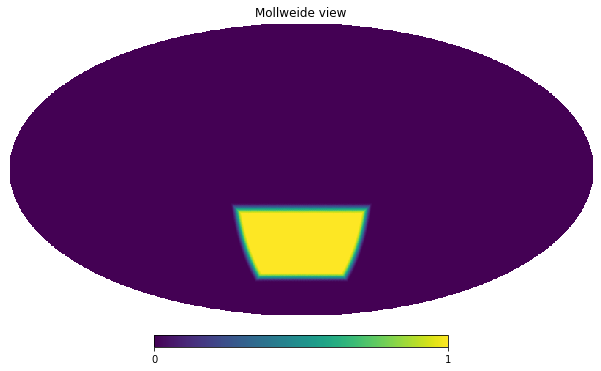

In [10]:
reload(mylib)
mask = mylib.get_mask(nside)
mask_apo = nmt.mask_apodization(mask, 6, apotype='C2')
hp.mollview(mask_apo)
fsky = len(mask_apo[(mask_apo!=0)])/npix
w2 = np.sum(mask_apo**2)/np.sum(mask)
w4 = np.sum(mask_apo**4)/np.sum(mask)
print(fsky *100)

In [5]:
reload(mylib)
sigmab = hp.nside2resol(nside)
fwhm = mylib.sigma2fwhm(sigmab)
bl = mylib.get_bl(nside)
b = nmt.NmtBin.from_nside_linear(nside, bin_size)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi

w_KS = nmt.NmtWorkspace()
f_KS = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl, purify_b=True)
w_KS.compute_coupling_matrix(f_KS, f_KS, b)

w_PCL = nmt.NmtWorkspace()
f_PCL = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl, purify_b=False)
w_PCL.compute_coupling_matrix(f_PCL, f_PCL, b)

w_comb = nmt.NmtWorkspace()
f_comb = nmt.NmtField(mask_apo, np.empty((1, npix)), beam=bl)
w_comb.compute_coupling_matrix(f_comb, f_comb, b)

mll = w_comb.get_coupling_matrix()
masked_ground_noise_cls = mll @ ground_noise_cls[2]
masked_ground_noise_cls[0:2] = 0
masked_ground_noise_cls_pol = np.array([mll@ground_noise_cls[1], np.zeros(lmax+1), np.zeros(lmax+1), mll@ground_noise_cls[2]])
masked_ground_noise_cls_pol[:,0:2] = 0
# masked_ground_noise_cls_pol = (w_PCL.get_coupling_matrix() @ np.concatenate(np.array([ground_noise_cls[1], np.zeros(lmax+1), np.zeros(lmax+1), ground_noise_cls[2]]))).reshape(4, lmax+1)

In [11]:
cl_KS = np.empty((n_sims, len(ells)))
cl_PCL = np.empty((n_sims, len(ells)))
cl_comb = np.empty((n_sims, len(ells)))

for i in tqdm(range(n_sims)):
    np.random.seed(i)
    input_map = hp.synfast(input_cls, nside, fwhm=fwhm, new=True)
    ground_noise = hp.synfast(ground_noise_cls, nside, new=True)
    sat_noise = hp.synfast(sat_noise_cls, nside, new=True)

    ground_map = input_map + ground_noise
    sat_map = input_map + sat_noise
    wienered_sat_map = mylib.wiener_filter(sat_map, input_cls, sat_noise_cls)
    comb_map = mask*ground_map + (1-mask)*wienered_sat_map
    B_map = hp.alm2map(hp.map2alm(comb_map)[2], nside)

    f_KS = nmt.NmtField(mask_apo, [ground_map[1], ground_map[2]], purify_b=True)
    f_PCL = nmt.NmtField(mask_apo, [ground_map[1], ground_map[2]], purify_b=False)
    f_comb = nmt.NmtField(mask_apo, [B_map])

    cl_KS[i] = nmt.compute_full_master(f_KS, f_KS, b, masked_ground_noise_cls_pol, workspace=w_KS)[3]
    cl_PCL[i] = nmt.compute_full_master(f_PCL, f_PCL, b, masked_ground_noise_cls_pol, workspace=w_PCL)[3]
    cl_comb[i] = nmt.compute_full_master(f_comb, f_comb, b, [masked_ground_noise_cls], workspace=w_comb)[0]
    
mean_KS = c2db*np.mean(cl_KS, axis=0)
std_KS = c2db*np.std(cl_KS, axis=0)

mean_PCL = c2db*np.mean(cl_PCL, axis=0)
std_PCL = c2db*np.std(cl_PCL, axis=0)

mean_comb = c2db*np.mean(cl_comb, axis=0)
std_comb = c2db*np.std(cl_comb, axis=0)

  0%|                                                   | 0/100 [00:00<?, ?it/s]/scratch/yuyang/destripe/mylib.py:54: RuntimeWarning: invalid value encountered in true_divide
  W_11 = (signal_cl[1] * full_cl[0] - signal_cl[3]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)
/scratch/yuyang/destripe/mylib.py:55: RuntimeWarning: invalid value encountered in true_divide
  W_01 = (signal_cl[3] * full_cl[1] - signal_cl[1]*full_cl[3]) / (full_cl[1] * full_cl[0] - full_cl[3]**2)
100%|█████████████████████████████████████████| 100/100 [43:37<00:00, 26.17s/it]


In [12]:
#Knox formula
bpw = w_PCL.get_bandpower_windows()[3,:,3]
nu_l = (2*np.arange(lmax+1)+1)*fsky*w2**2/w4*bin_size

knox = (input_cls[2] + ground_noise_cls[2]/bl**2) * np.sqrt(2/nu_l)

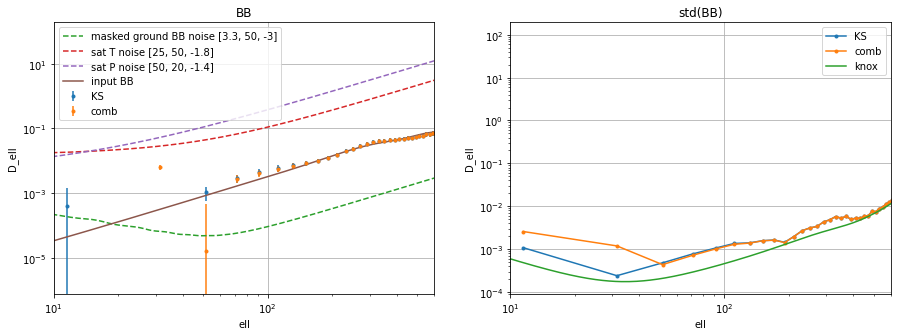

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].errorbar(ells, mean_KS, yerr=std_KS, fmt='.', label='KS')
# axes[0].errorbar(ells, mean_PCL, yerr=std_PCL, fmt='.', label='PCL')
axes[0].errorbar(ells, mean_comb, yerr=std_comb, fmt='.', label='comb')
axes[0].plot(c2d*masked_ground_noise_cls, linestyle='dashed', label=f'masked ground BB noise {ground_P_noise_props}')
axes[0].plot(c2d*sat_noise_cls[0], linestyle='dashed', label=f'sat T noise {sat_T_noise_props}')
axes[0].plot(c2d*sat_noise_cls[1], linestyle='dashed', label=f'sat P noise {sat_P_noise_props}')
axes[0].plot(c2d*input_cls[2], label='input BB')
axes[0].set_title('BB')

axes[1].plot(ells, std_KS, marker='.', label='KS')
# axes[1].plot(ells, std_PCL, marker='.', label='PCL')
axes[1].plot(ells, std_comb, marker='.',label='comb')
axes[1].plot(c2d*knox, label='knox')
axes[1].set_title('std(BB)')

for ax in axes.flatten():
    ax.legend()
    ax.set_xlim([10,600])
    ax.loglog()
    ax.grid()
    ax.set_xlabel('ell')
    ax.set_ylabel('D_ell')